# Import

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Data

In [154]:
path = "../data/train.csv"
data = pd.read_csv(path)
df = data.copy()
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data explo

## Shape, size, info

In [155]:
df.shape

(7613, 5)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Balanced?

In [157]:
df['target'].value_counts(1)

0    0.57034
1    0.42966
Name: target, dtype: float64

## Nan number ?

In [158]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Lets drop location and id columns and explore keyword column

## keyword column

In [168]:
df_copy = df.copy()

In [169]:
df_copy.drop(columns=['id'], inplace=True)

In [170]:
df_copy.dropna(inplace=True)

In [171]:
df_copy.shape

(5080, 4)

In [163]:
df_copy['keyword'].unique()

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

For the moment i will not use the keyword column, because of the nan number, but i think it is an interesting data

## data viz

Text(0.5, 0, 'Count of Keywords')

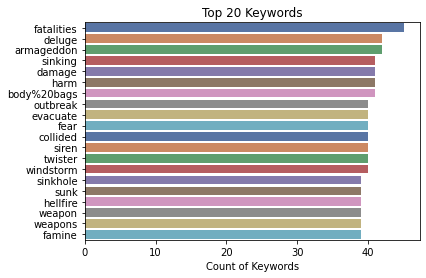

In [164]:
chains=df_copy['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

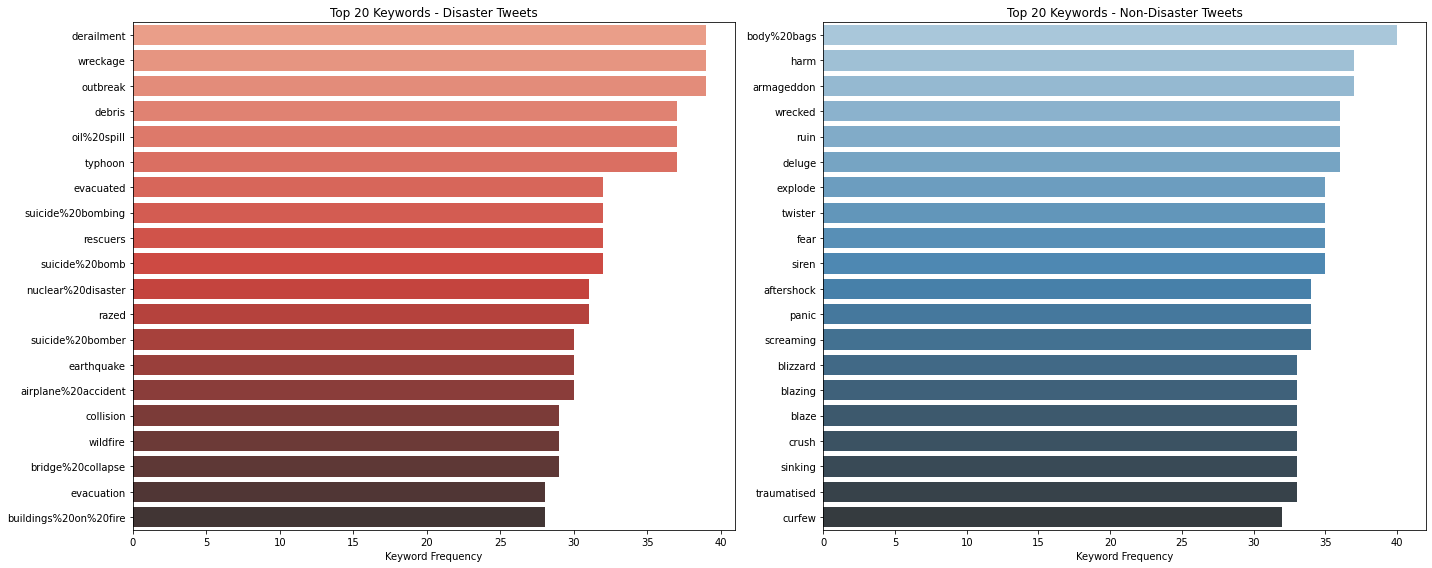

In [166]:
disaster_keywords = df_copy.loc[df_copy["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = df_copy.loc[df_copy["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 20 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()


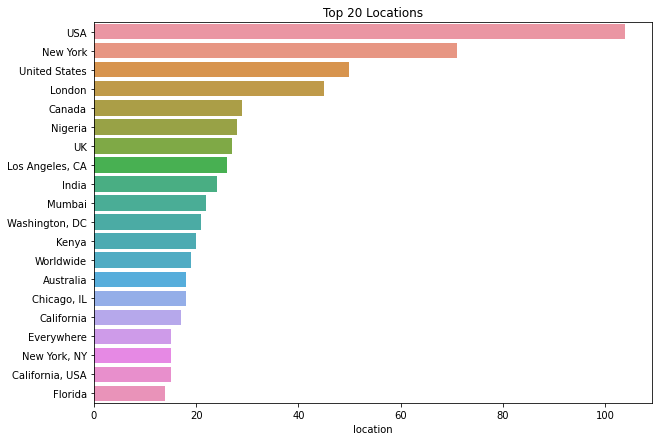

In [172]:
locations = df_copy["location"].value_counts()
plt.figure(figsize=(10,7))


sns.barplot(y=locations[0:20].index, x=locations[0:20], orient='h')

plt.title("Top 20 Locations")
plt.show()

# Data preprocess

## Clean data

In [ ]:
# approche de base : on se concentre sur les commentaires uniquement
df.drop(columns=['location', 'id', 'keyword'], inplace=True)

In [13]:
def clean_data(text, remove_punctuations=False, lower_case=False,remove_numb=False, remove_symbol=False):
    for index, sentence in enumerate(text) : 
        if remove_punctuations == True :
            for punctuation in string.punctuation:
                sentence = sentence.replace(punctuation, '')
        if lower_case == True :
            sentence = sentence.lower()
        if remove_numb == True :
            sentence = ''.join(word for word in sentence if not word.isdigit())
        if remove_symbol == True :
            sentence = ''.join(char if char not in ['#', '@', "&", "\(", "\)", "_", "$", "£", "%", "/", "\\"] else ' ' for char in sentence)
        text[index] = sentence
    return text

In [452]:
df['text'] = clean_data(df['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [453]:
stop_words = set(stopwords.words('english'))
for index, com in enumerate(df['text']) :
    df['text'][index] = word_tokenize(df['text'][index])
    df['text'][index] = [t for t in df['text'][index] if t not in stop_words]
    
df.head()

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/1419358768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = word_tokenize(df['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/1419358768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = [t for t in df['text'][index] if t not in stop_words]


,text,target
0,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,"[forest, fire, near, la, ronge, sask, canada]",1
2,"[residents, asked, shelter, place, notified, o...",1
3,"[people, receive, wildfires, evacuation, order...",1
4,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [454]:
lemmatizer = WordNetLemmatizer()
for index, com in enumerate(df['text']) :
    df['text'][index] = [lemmatizer.lemmatize(word) for word in df['text'][index]]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/1521806483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = [lemmatizer.lemmatize(word) for word in df['text'][index]]


In [455]:
df['text']

0       [deed, reason, earthquake, may, allah, forgive...
1           [forest, fire, near, la, ronge, sask, canada]
2       [resident, asked, shelter, place, notified, of...
3       [people, receive, wildfire, evacuation, order,...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, holding, bridge, collapse,...
7609    [ariaahrary, thetawniest, control, wild, fire,...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, home, razed, northern, california, wi...
Name: text, Length: 7613, dtype: object

## Vocab Size

In [456]:
list_all_words = []
for sentence in df['text'] :
    for word in sentence :
        list_all_words.append(word)

In [457]:
vocab_size = len(set(list_all_words))
vocab_size

20395

In [458]:
# je passe les listes de mots en string
for index, com in enumerate(df['text']) :
    df['text'][index] = ' '.join(df['text'][index])   

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/3410932662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][index] = ' '.join(df['text'][index])


In [459]:
df['text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    ariaahrary thetawniest control wild fire calif...
7610                utckm volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

In [460]:
# je fais une copie pour une autre approche
df_copy_word2vec = df.copy()
df_copy_word2vec

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1
...,...,...
7608,two giant crane holding bridge collapse nearby...,1
7609,ariaahrary thetawniest control wild fire calif...,1
7610,utckm volcano hawaii httptcozdtoydebj,1
7611,police investigating ebike collided car little...,1


In [461]:
# je transform les mots en int
tk = Tokenizer()
tk.fit_on_texts(df['text'])
df['text'] = tk.texts_to_sequences(df['text'])


In [462]:
X = df['text']
X

0                     [4018, 452, 156, 69, 1399, 4019, 6]
1                    [107, 1, 149, 504, 5984, 5985, 1067]
2       [1530, 1400, 1879, 453, 5986, 319, 162, 1879, ...
3                            [10, 4020, 76, 162, 361, 32]
4          [31, 1068, 111, 5987, 1692, 187, 76, 5988, 97]
                              ...                        
7608        [55, 692, 1047, 940, 255, 83, 563, 22, 20394]
7609    [5959, 5960, 715, 214, 1, 32, 92, 116, 294, 12...
7610                              [3755, 446, 1388, 5954]
7611    [21, 991, 2838, 259, 43, 195, 4704, 2838, 1701...
7612          [131, 22, 451, 116, 32, 76, 522, 11, 20395]
Name: text, Length: 7613, dtype: object

In [463]:
# je pad
X_pad = pad_sequences(X, dtype='float32', padding='post')
X_pad

array([[4.018e+03, 4.520e+02, 1.560e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.070e+02, 1.000e+00, 1.490e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.530e+03, 1.400e+03, 1.879e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [3.755e+03, 4.460e+02, 1.388e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.100e+01, 9.910e+02, 2.838e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.310e+02, 2.200e+01, 4.510e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)

In [464]:
# calcul sequence max
Max_sentence_length = max([len(com) for com in X_pad])
Max_sentence_length

23

In [465]:
# spit data
X_pad_train = X_pad[:5000]
X_pad_test = X_pad[5000:]
y_train = df['target'][:5000]
y_test = df['target'][5000:]

# Model personnal embedding

In [498]:
#Embedding(input_dim=vocab_size, output_dim=emb_dim, mask_zero=True)
from tensorflow.keras import layers, Sequential
# Size of your embedding space = size to represent each word
embedding_size = 100
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size+1,
input_length=Max_sentence_length, 
output_dim=embedding_size,
mask_zero=True))
model.add(layers.LSTM(500))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 23, 100)           2039600   
_________________________________________________________________
lstm_29 (LSTM)               (None, 500)               1202000   
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 501       
Total params: 3,242,101
Trainable params: 3,242,101
Non-trainable params: 0
_________________________________________________________________


In [520]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
es = EarlyStopping(patience=6, restore_best_weights=True)
loss=BinaryCrossentropy(from_logits=True) # default from_logits=False
#metrics=[keras.metrics.BinaryAccuracy()]
model.compile(loss=loss,
              optimizer='rmsprop',
              metrics=['accuracy', 'Recall'])
model.fit(X_pad_train, y_train, epochs=20, batch_size=16, verbose=1, callbacks=[es], validation_split=0.3)

Epoch 1/20


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


219/219 [==============================] - 14s 54ms/step - loss: 0.3475 - accuracy: 0.8657 - recall: 0.7747 - val_loss: 0.5993 - val_accuracy: 0.7040 - val_recall: 0.6652
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.2476 - accuracy: 0.9126 - recall: 0.8510 - val_loss: 0.6158 - val_accuracy: 0.7013 - val_recall: 0.6608
Epoch 3/20
219/219 [==============================] - 11s 48ms/step - loss: 0.1669 - accuracy: 0.9431 - recall: 0.9082 - val_loss: 0.6761 - val_accuracy: 0.6860 - val_recall: 0.6416
Epoch 4/20
219/219 [==============================] - 11s 49ms/step - loss: 0.1162 - accuracy: 0.9620 - recall: 0.9357 - val_loss: 1.0804 - val_accuracy: 0.6227 - val_recall: 0.7581
Epoch 5/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0845 - accuracy: 0.9737 - recall: 0.9605 - val_loss: 0.8568 - val_accuracy: 0.6433 - val_recall: 0.6962
Epoch 6/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0615 - accuracy: 0.9843

In [521]:
model.evaluate(X_pad_test, y_test)

82/82 [==============================] - 2s 22ms/step - loss: 0.5177 - accuracy: 0.7386 - recall: 0.7383


[0.5177033543586731, 0.7386146187782288, 0.7383177280426025]

# challenge kaggle

In [652]:
path_test = '../data/test.csv'
test_keras = pd.read_csv(path_test)
test_keras.head()


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [653]:
test_keras.tail()

,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [642]:
test_keras.drop(columns=['location', 'keyword'], inplace=True)

In [643]:
test_keras['text'] = clean_data(test_keras['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [644]:
for index, com in enumerate(test_keras['text']) :
    test_keras['text'][index] = word_tokenize(test_keras['text'][index])
    test_keras['text'][index] = [t for t in test_keras['text'][index] if t not in stop_words]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2197476742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras['text'][index] = word_tokenize(test_keras['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2197476742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras['text'][index] = [t for t in test_keras['text'][index] if t not in stop_words]


In [645]:
for index, com in enumerate(test_keras['text']) :
    test_keras['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras['text'][index]]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2754747523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras['text'][index]]


In [646]:
for index, com in enumerate(test_keras['text']) :
    test_keras['text'][index] = ' '.join(test_keras['text'][index])   

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2163400442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras['text'][index] = ' '.join(test_keras['text'][index])


In [647]:
#tk.fit_on_texts(df['text'])
test_keras['text'] = tk.texts_to_sequences(test_keras['text'])

In [648]:
X_kaggle_test = test_keras['text']
X_kaggle_test_pad = pad_sequences(X_kaggle_test, dtype='float32', padding='post', maxlen=23)

In [649]:
res_test = model.predict(X_kaggle_test_pad)
len(res_test)

3263

In [650]:
res_binary = []
for num in res_test : 
    if num< 0.5:
        res_binary.append(0)
    else :
        res_binary.append(1)
len(res_binary)

3263

In [654]:
res_test = pd.DataFrame(res_binary, columns=['target'])
res_test.shape

(3263, 1)

In [656]:
res_test['id']= test_keras['id']
res_test = res_test[['id', 'target']]
res_test
#res_test[res_test['id']== 2275]

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [657]:
res_test.to_csv('challenge_kaggle.csv', index=False)

# Approche avec preprocess different :

## preprocess_2

Au lieu de supprimer et donc perdre les informations des colonnes keyword/location, je vais les ajouter au texte

In [825]:
df_2 = data.copy()
df_2.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [826]:
df_2['keyword'] = df_2['keyword'].replace(np.nan, '')
df_2['location'] = df_2['location'].replace(np.nan, '')

In [827]:
df_2['text'] = df_2['text'].astype('str') +' '+ df_2['keyword'].astype('str')
df_2['text'] = df_2['text'].astype('str') +' '+ df_2['location'].astype('str')

In [828]:
df_2['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all  '

In [829]:
df_2['text'][32]

'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw ablaze Est. September 2012 - Bristol'

In [830]:
df_2['text'] = clean_data(df_2['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [831]:
stop_words = set(stopwords.words('english'))
for index, com in enumerate(df_2['text']) :
    df_2['text'][index] = word_tokenize(df_2['text'][index])
    df_2['text'][index] = [t for t in df_2['text'][index] if t not in stop_words]
    
df_2.head()

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/1174684775.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['text'][index] = word_tokenize(df_2['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/1174684775.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['text'][index] = [t for t in df_2['text'][index] if t not in stop_words]


,id,keyword,location,text,target
0,1,,,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,,,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,,,"[residents, asked, shelter, place, notified, o...",1
3,6,,,"[people, receive, wildfires, evacuation, order...",1
4,7,,,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [832]:
lemmatizer = WordNetLemmatizer()
for index, com in enumerate(df_2['text']) :
    df_2['text'][index] = [lemmatizer.lemmatize(word) for word in df_2['text'][index]]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2459288223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['text'][index] = [lemmatizer.lemmatize(word) for word in df_2['text'][index]]


In [833]:
df_2['text'][32]

['always',
 'try',
 'bring',
 'heavy',
 'metal',
 'rt',
 'httptcoyaoexngw',
 'ablaze',
 'est',
 'september',
 'bristol']

from nltk.corpus import words

for index, com in enumerate(df_2['text']) :
    df_2['text'][index] = [word for word in df_2['text'][index] if wordnet.synsets(word) != []]

In [834]:
list_all_words = []
for sentence in df_2['text'] :
    for word in sentence :
        list_all_words.append(word)

In [835]:
vocab_size = len(set(list_all_words))
vocab_size

22172

In [836]:
# je transform les mots en int
tk = Tokenizer()
tk.fit_on_texts(df_2['text'])
df_2['text'] = tk.texts_to_sequences(df_2['text'])


In [837]:
X_2 = df_2['text']
X_2

0                      [4476, 570, 89, 96, 1603, 4477, 7]
1                      [231, 2, 279, 294, 6639, 4478, 78]
2       [1483, 1604, 2126, 498, 6640, 466, 97, 2126, 4...
3                             [13, 4479, 35, 97, 483, 12]
4         [52, 1169, 240, 6641, 1396, 109, 35, 6642, 185]
                              ...                        
7608       [75, 826, 1213, 1088, 430, 64, 696, 37, 22171]
7609    [6611, 6612, 853, 366, 2, 12, 171, 188, 447, 3...
7610                               [4184, 295, 952, 6604]
7611    [19, 1153, 3196, 118, 62, 352, 1856, 3196, 192...
7612          [292, 37, 238, 188, 12, 35, 645, 11, 22172]
Name: text, Length: 7613, dtype: object

In [838]:
# je pad
X_pad_2 = pad_sequences(X_2, dtype='float32', padding='post', maxlen=24)
X_pad_2

array([[4.476e+03, 5.700e+02, 8.900e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.310e+02, 2.000e+00, 2.790e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.483e+03, 1.604e+03, 2.126e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [4.184e+03, 2.950e+02, 9.520e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.900e+01, 1.153e+03, 3.196e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.920e+02, 3.700e+01, 2.380e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)

In [839]:
# calcul sequence max
Max_sentence_length = max([len(com) for com in X_pad_2])
Max_sentence_length

24

In [840]:
# spit data
X_pad_train_2 = X_pad_2[:6000]
X_pad_test_2 = X_pad_2[6000:]
y_train_2 = df['target'][:6000]
y_test_2 = df['target'][6000:]

## model_2

In [877]:
#Embedding(input_dim=vocab_size, output_dim=emb_dim, mask_zero=True)
from tensorflow.keras import layers, Sequential
# Size of your embedding space = size to represent each word
embedding_size = 100
model_2 = Sequential()
model_2.add(layers.Embedding(input_dim=vocab_size+1,input_length=Max_sentence_length, output_dim=embedding_size,mask_zero=True))
model_2.add(layers.LSTM(200))
model.add(layers.Dropout(rate=0.2))
model_2.add(layers.Dense(10))
model.add(layers.Dropout(rate=0.2))
model_2.add(layers.Dense(1, activation="sigmoid"))
model_2.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 24, 100)           2217300   
_________________________________________________________________
lstm_35 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dense_45 (Dense)             (None, 10)                2010      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 11        
Total params: 2,460,121
Trainable params: 2,460,121
Non-trainable params: 0
_________________________________________________________________


In [878]:
from keras import backend as K
import tensorflow as tf
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [879]:

es = EarlyStopping(patience=10, restore_best_weights=True)
loss=BinaryCrossentropy(from_logits=True) # default from_logits=False
#metrics=[keras.metrics.BinaryAccuracy()]
model_2.compile(loss=loss,
              optimizer='adam',
              metrics=[f1_m,'accuracy', 'Recall'])
model_2.fit(X_pad_train_2, y_train_2, epochs=100, batch_size=16, verbose=1, callbacks=[es], validation_split=0.3)

Epoch 1/100
263/263 [==============================] - 9s 25ms/step - loss: 0.5312 - f1_m: 0.5792 - accuracy: 0.7395 - recall: 0.5336 - val_loss: 0.5777 - val_f1_m: 0.4320 - val_accuracy: 0.7128 - val_recall: 0.4935
Epoch 2/100
263/263 [==============================] - 6s 21ms/step - loss: 0.2325 - f1_m: 0.8910 - accuracy: 0.9157 - recall: 0.8686 - val_loss: 0.6836 - val_f1_m: 0.5442 - val_accuracy: 0.6733 - val_recall: 0.7390
Epoch 3/100
263/263 [==============================] - 6s 21ms/step - loss: 0.0793 - f1_m: 0.9697 - accuracy: 0.9764 - recall: 0.9679 - val_loss: 0.8493 - val_f1_m: 0.5015 - val_accuracy: 0.6878 - val_recall: 0.6292
Epoch 4/100
263/263 [==============================] - 6s 21ms/step - loss: 0.0476 - f1_m: 0.9853 - accuracy: 0.9888 - recall: 0.9851 - val_loss: 0.8372 - val_f1_m: 0.5291 - val_accuracy: 0.6706 - val_recall: 0.6951
Epoch 5/100
263/263 [==============================] - 6s 21ms/step - loss: 0.0232 - f1_m: 0.9923 - accuracy: 0.9945 - recall: 0.9914 - 

## test du model

In [886]:
path_test = '../data/test.csv'
test_keras_2 = pd.read_csv(path_test)

In [887]:
test_keras_2['keyword'] = test_keras_2['keyword'].replace(np.nan, '')
test_keras_2['location'] = test_keras_2['location'].replace(np.nan, '')

In [888]:
test_keras_2['text'] = test_keras_2['text'].astype('str') +' '+ test_keras_2['keyword'].astype('str')
test_keras_2['text'] = test_keras_2['text'].astype('str') +' '+ test_keras_2['location'].astype('str')

In [889]:
test_keras_2['text'] = clean_data(test_keras_2['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [890]:

for index, com in enumerate(test_keras_2['text']) :
    test_keras_2['text'][index] = word_tokenize(test_keras_2['text'][index])
    test_keras_2['text'][index] = [t for t in test_keras_2['text'][index] if t not in stop_words]
    


/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2361971375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_2['text'][index] = word_tokenize(test_keras_2['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/2361971375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_2['text'][index] = [t for t in test_keras_2['text'][index] if t not in stop_words]


In [891]:
test_keras_2['text']

0                        [happened, terrible, car, crash]
1       [heard, earthquake, different, cities, stay, s...
2       [forest, fire, spot, pond, geese, fleeing, acr...
3              [apocalypse, lighting, spokane, wildfires]
4               [typhoon, soudelor, kills, china, taiwan]
                              ...                        
3258    [earthquake, safety, los, angeles, ûò, safety...
3259    [storm, ri, worse, last, hurricane, cityampoth...
3260    [green, line, derailment, chicago, httptcoutbx...
3261    [meg, issues, hazardous, weather, outlook, hwo...
3262    [cityofcalgary, activated, municipal, emergenc...
Name: text, Length: 3263, dtype: object

In [892]:

for index, com in enumerate(test_keras_2['text']) :
    test_keras_2['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras_2['text'][index]]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_41468/3330642516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_2['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras_2['text'][index]]


from nltk.corpus import words

for index, com in enumerate(test_keras_2['text']) :
    test_keras_2['text'][index] = [word for word in test_keras_2['text'][index] if wordnet.synsets(word) != []]

In [893]:
# je transform les mots en int

test_keras_2['text'] = tk.texts_to_sequences(test_keras_2['text'])


In [894]:
test_keras_2 = test_keras_2['text']
test_keras_2

0                                     [922, 1932, 62, 26]
1                     [486, 89, 1214, 36, 529, 1698, 323]
2                [231, 2, 761, 3477, 4973, 835, 467, 425]
3                                   [234, 3827, 2189, 35]
4                              [210, 792, 244, 392, 1222]
                              ...                        
3258                      [89, 1114, 269, 288, 440, 1114]
3259    [25, 3101, 1154, 110, 125, 8953, 8954, 291, 89...
3260                                 [934, 641, 126, 298]
3261             [6098, 443, 209, 353, 1744, 1906, 15441]
3262                    [5787, 2795, 1591, 14, 155, 6067]
Name: text, Length: 3263, dtype: object

In [895]:
# je pad
test_pad_keras_2 = pad_sequences(test_keras_2, dtype='float32', padding='post', maxlen=24)
test_pad_keras_2

array([[9.220e+02, 1.932e+03, 6.200e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [4.860e+02, 8.900e+01, 1.214e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.310e+02, 2.000e+00, 7.610e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [9.340e+02, 6.410e+02, 1.260e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.098e+03, 4.430e+02, 2.090e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.787e+03, 2.795e+03, 1.591e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)

In [896]:
res_test_2 = model_2.predict(test_pad_keras_2)

In [897]:
res_binary_2 = []
for num in res_test_2 : 
    if num< 0.5:
        res_binary_2.append(0)
    else :
        res_binary_2.append(1)
len(res_binary_2)

3263

In [898]:
res_test_2 = pd.DataFrame(res_binary_2, columns=['target'])
res_test_2.shape

(3263, 1)

In [899]:
res_test_2['id']= test_keras['id']
res_test_2 = res_test_2[['id', 'target']]
res_test_2
#res_test[res_test['id']== 2275]

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0


In [902]:
res_test_2.to_csv('challenge_kaggle_4_nlp.csv', index=False)

# approche transfer learning

In [179]:
df_3 = data.copy()

In [79]:
import gensim.downloader
word2vec_transfer = gensim.downloader.load('glove-twitter-50')
len(word2vec_transfer)

[=====---------------------------------------------] 11.7% 23.4/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 34.4% 68.7/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================----------------------] 57.2% 114.0/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.8% 163.2/199.5MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 199.5/199.5MB downloaded


1193514

In [180]:
df_3['keyword'] = df_3['keyword'].replace(np.nan, '')
df_3['location'] = df_3['location'].replace(np.nan, '')
df_3['text'] = df_3['text'].astype('str') +' '+ df_3['keyword'].astype('str')
df_3['text'] = df_3['text'].astype('str') +' '+ df_3['location'].astype('str')
df_3['text'] = clean_data(df_3['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [181]:
stop_words = set(stopwords.words('english'))
for index, com in enumerate(df_3['text']) :
    df_3['text'][index] = word_tokenize(df_3['text'][index])
    df_3['text'][index] = [t for t in df_3['text'][index] if t not in stop_words]
df_3.head()

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/3279767701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['text'][index] = word_tokenize(df_3['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/3279767701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['text'][index] = [t for t in df_3['text'][index] if t not in stop_words]


,id,keyword,location,text,target
0,1,,,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,,,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,,,"[residents, asked, shelter, place, notified, o...",1
3,6,,,"[people, receive, wildfires, evacuation, order...",1
4,7,,,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [182]:
df_3['text'][32]

['always',
 'try',
 'bring',
 'heavy',
 'metal',
 'rt',
 'httptcoyaoexngw',
 'ablaze',
 'est',
 'september',
 'bristol']

In [183]:
lemmatizer = WordNetLemmatizer()
for index, com in enumerate(df_3['text']) :
    df_3['text'][index] = [lemmatizer.lemmatize(word) for word in df_3['text'][index]]
df_3.head()

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/2715600253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['text'][index] = [lemmatizer.lemmatize(word) for word in df_3['text'][index]]


,id,keyword,location,text,target
0,1,,,"[deed, reason, earthquake, may, allah, forgive...",1
1,4,,,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,,,"[resident, asked, shelter, place, notified, of...",1
3,6,,,"[people, receive, wildfire, evacuation, order,...",1
4,7,,,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [184]:
X_3 = df_3['text']
y_3 =df_3['target'] 
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.3, random_state=42)

In [85]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return np.array(embed)

# Embed the training and test sentences
X_train_embed_3 = embedding(word2vec_transfer, X_train_3)
X_test_embed_3 = embedding(word2vec_transfer, X_test_3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/15132629.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(embed)


In [86]:
list_all_words = []
for sentence in X_3 :
    for word in sentence :
        list_all_words.append(word)
vocab_size = len(set(list_all_words))
vocab_size

22178

In [87]:
# calcul sequence max
Max_sentence_length = max([len(com) for com in X_3])
Max_sentence_length

31

In [92]:
# je pad
X_pad_train_embed_3 = pad_sequences(X_train_embed_3, dtype='float32', padding='post', maxlen=31, value=0.)
X_pad_test_embed_3 = pad_sequences(X_test_embed_3, dtype='float32', padding='post', maxlen=31, value=0.)

In [93]:
X_pad_train_embed_3.shape

(5329, 31, 50)

## Model RNN

In [90]:
from keras import backend as K
import tensorflow as tf
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [95]:
model_3 = Sequential()
model_3.add(layers.Masking(mask_value=0., input_shape=(31,50)))
model_3.add(layers.LSTM(200))
model_3.add(layers.Dropout(rate=0.2))
model_3.add(layers.Dense(60, activation="relu"))
model_3.add(layers.Dropout(rate=0.2))
model_3.add(layers.Dense(1, activation="sigmoid"))

es = EarlyStopping(patience=10, restore_best_weights=True)
loss=BinaryCrossentropy(from_logits=False) # default from_logits=False

model_3.compile(loss=loss,
              optimizer='adam',
              metrics=[f1_m,'accuracy', 'Recall'])
model_3.fit(X_pad_train_embed_3, y_train_3, epochs=100, batch_size=8, verbose=1, callbacks=[es], validation_split=0.3)


Epoch 1/100
467/467 [==============================] - 11s 18ms/step - loss: 0.5288 - f1_m: 0.6429 - accuracy: 0.7515 - recall: 0.6456 - val_loss: 0.5197 - val_f1_m: 0.6073 - val_accuracy: 0.7586 - val_recall: 0.5552
Epoch 2/100
467/467 [==============================] - 7s 15ms/step - loss: 0.4792 - f1_m: 0.6679 - accuracy: 0.7796 - recall: 0.6518 - val_loss: 0.5044 - val_f1_m: 0.6624 - val_accuracy: 0.7580 - val_recall: 0.6962
Epoch 3/100
467/467 [==============================] - 7s 15ms/step - loss: 0.4487 - f1_m: 0.7097 - accuracy: 0.8048 - recall: 0.7056 - val_loss: 0.4961 - val_f1_m: 0.6763 - val_accuracy: 0.7767 - val_recall: 0.6890
Epoch 4/100
467/467 [==============================] - 7s 15ms/step - loss: 0.4225 - f1_m: 0.7243 - accuracy: 0.8158 - recall: 0.7168 - val_loss: 0.4958 - val_f1_m: 0.6478 - val_accuracy: 0.7611 - val_recall: 0.6599
Epoch 5/100
467/467 [==============================] - 7s 15ms/step - loss: 0.4036 - f1_m: 0.7349 - accuracy: 0.8247 - recall: 0.7242 -

In [97]:
model_3.evaluate(X_pad_test_embed_3, y_test_3)

72/72 [==============================] - 1s 11ms/step - loss: 0.4633 - f1_m: 0.7277 - accuracy: 0.7920 - recall: 0.6812


[0.46327051520347595,
 0.7276753783226013,
 0.7920315265655518,
 0.6811594367027283]

## CNN model

In [96]:
model_cnn= Sequential()
model_cnn.add(layers.Masking(mask_value=0., input_shape=(31,50)))
model_cnn.add(layers.Conv1D(150, kernel_size=3))
model_cnn.add(layers.Conv1D(100, kernel_size=3))
model_cnn.add(layers.Conv1D(50, kernel_size=3))
model_cnn.add(layers.Dense(4, activation="relu"))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(1, activation="sigmoid"))

es = EarlyStopping(patience=10, restore_best_weights=True)
loss=BinaryCrossentropy(from_logits=True) # default from_logits=False

model_cnn.compile(loss=loss,
              optimizer='adam',
              metrics=[f1_m,'accuracy', 'Recall'])
model_cnn.fit(X_pad_train_embed_3, y_train_3, epochs=100, batch_size=8, verbose=1, callbacks=[es], validation_split=0.3)

Epoch 1/100


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


467/467 [==============================] - 2s 3ms/step - loss: 0.6437 - f1_m: 0.4921 - accuracy: 0.6501 - recall: 0.5071 - val_loss: 0.7276 - val_f1_m: 0.6611 - val_accuracy: 0.6992 - val_recall: 0.8081
Epoch 2/100
467/467 [==============================] - 1s 3ms/step - loss: 0.5301 - f1_m: 0.6419 - accuracy: 0.7488 - recall: 0.6456 - val_loss: 0.5442 - val_f1_m: 0.6351 - val_accuracy: 0.7361 - val_recall: 0.6468
Epoch 3/100
467/467 [==============================] - 1s 3ms/step - loss: 0.4958 - f1_m: 0.6660 - accuracy: 0.7689 - recall: 0.6667 - val_loss: 0.5513 - val_f1_m: 0.6416 - val_accuracy: 0.7411 - val_recall: 0.6570
Epoch 4/100
467/467 [==============================] - 1s 3ms/step - loss: 0.4799 - f1_m: 0.6820 - accuracy: 0.7710 - recall: 0.6809 - val_loss: 0.5590 - val_f1_m: 0.6566 - val_accuracy: 0.7498 - val_recall: 0.6875
Epoch 5/100
467/467 [==============================] - 1s 3ms/step - loss: 0.4633 - f1_m: 0.6906 - accuracy: 0.7775 - recall: 0.6939 - val_loss: 0.5500 

In [98]:
model_cnn.evaluate(X_pad_test_embed_3, y_test_3)

72/72 [==============================] - 0s 2ms/step - loss: 0.5244 - f1_m: 0.6712 - accuracy: 0.7408 - recall: 0.6470


[0.5243917107582092,
 0.6711615324020386,
 0.7408056259155273,
 0.6469979286193848]

## test kaggle

In [139]:
path_test = '../data/test.csv'
test_keras_4 = pd.read_csv(path_test)

In [140]:
test_keras_4['keyword'] = test_keras_4['keyword'].replace(np.nan, '')
test_keras_4['location'] = test_keras_4['location'].replace(np.nan, '')
test_keras_4['text'] = test_keras_4['text'].astype('str') +' '+ test_keras_4['keyword'].astype('str')
test_keras_4['text'] = test_keras_4['text'].astype('str') +' '+ test_keras_4['location'].astype('str')
test_keras_4['text'] = clean_data(test_keras_4['text'], remove_punctuations=True, lower_case=True,remove_numb=True, remove_symbol=True)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/2174276971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[index] = sentence


In [141]:
for index, com in enumerate(test_keras_4['text']) :
    test_keras_4['text'][index] = word_tokenize(test_keras_4['text'][index])
    test_keras_4['text'][index] = [t for t in test_keras_4['text'][index] if t not in stop_words]
    

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/2954110916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_4['text'][index] = word_tokenize(test_keras_4['text'][index])
/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/2954110916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_4['text'][index] = [t for t in test_keras_4['text'][index] if t not in stop_words]


In [142]:
lemmatizer = WordNetLemmatizer()
for index, com in enumerate(test_keras_4['text']) :
    test_keras_4['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras_4['text'][index]]

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/3741709548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_keras_4['text'][index] = [lemmatizer.lemmatize(word) for word in test_keras_4['text'][index]]


In [143]:
X_4_test_kaggle = test_keras_4['text']

In [144]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return np.array(embed)



X_test_kaggle_embed = embedding(word2vec_transfer, X_4_test_kaggle)
X_test_kaggle_embed.shape

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_99167/3236874905.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(embed)


(3263,)

In [145]:
X_test_pad_kaggle_embed = pad_sequences(X_test_kaggle_embed, dtype='float32', padding='post', maxlen=31, value=0.)

In [146]:
X_test_pad_kaggle_embed.shape

(3263, 31, 50)

In [147]:
y_pred = model_3.predict(X_test_pad_kaggle_embed)
y_pred_cnn = model_cnn.predict(X_test_pad_kaggle_embed)

In [148]:
res_binary_4 = []
for num in y_pred : 
    if num< 0.5:
        res_binary_4.append(0)
    else :
        res_binary_4.append(1)
len(res_binary_4)

3263

In [149]:
res_binary_cnn = []
for num in y_pred_cnn : 
    if num< 0.5:
        res_binary_cnn.append(0)
    else :
        res_binary_cnn.append(1)
len(res_binary_cnn)

3263

In [150]:
res_test_4 = pd.DataFrame(res_binary_4, columns=['target'])
res_test_cnn = pd.DataFrame(res_binary_cnn, columns=['target'])

In [151]:
res_test_4['id']= test_keras_4['id']
res_test_cnn['id']= test_keras_4['id']
res_test_4 = res_test_4[['id', 'target']]
res_test_cnn = res_test_cnn[['id', 'target']]


In [152]:
res_test_4.to_csv('challenge_kaggle_5_nlp.csv', index=False)
res_test_4.to_csv('challenge_kaggle_cnn_nlp.csv', index=False)

# Bayes

In [177]:
def return_sentence(text):
    sentence = ' '.join(word for word in text)
    return sentence

In [185]:
X_3 = X_3.map(return_sentence)
X_3

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    ariaahrary thetawniest control wild fire calif...
7610                utckm volcano hawaii httptcozdtoydebj
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

In [186]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_3)
y = y_3
nb_model = MultinomialNB()
nb_model.fit(X,y)
nb_model.score(X,y)

0.8911073164324183

In [189]:
X_4_test_kaggle = X_4_test_kaggle.map(return_sentence)

In [190]:
X_4_test_kaggle = vectorizer.transform(X_4_test_kaggle)

In [194]:
res_bayes = nb_model.predict(X_4_test_kaggle)
res_bayes = pd.DataFrame(res_bayes, columns=['target'])

In [195]:
res_bayes['id']= test_keras_4['id']
res_bayes = res_bayes[['id', 'target']]

In [197]:
res_bayes.to_csv('../test_challenge_kaggle/challenge_kaggle_6_nlp.csv', index=False)